This code primarily detects the edges of the almost spherical particles and outputs the diameter

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import skimage.measure
import pylab
from skimage.filters import difference_of_gaussians, window, gaussian
from scipy.optimize import curve_fit
import radial_functions as fun
from radial_functions import see_all_contours, hyperbolic
import math
import contextlib


In [45]:
#user defined parameters

res = 325 #nm per px
shift = -0
step_size = 0.25 #um

In [46]:
mpl.rc('figure', figsize=(10,5))
mpl.rc('image', cmap='gray')
#matplotlib specs

@pims.pipeline
def conv_gray(frame):
    one_channel = frame[:,:,1]
    return one_channel

frames =(pims.open('/Volumes/LAB_AKALANKA/April2024/Cropped_0.25umstep_325nmpx/*.tif'))
img = frames[125:217]

#fun.see_contour(img[95],True)

In [47]:
def Get_Center(img,frameStart, frameEnd, plott):

    img = img[frameStart:frameEnd]
    contour = fun.see_all_contours(img,100)
    xpos = np.asarray(contour['x'])
    ypos = np.asarray(contour['y'])
    radius = np.asarray(contour['radius'])[:]

    #Plot to see the image
    #call to plot_frame
    if plott==True:
        plot_frame(frames[frameStart],xpos,ypos,radius)

    return (xpos, ypos)

#plot contour inside frame
def plot_frame(frame,xpos,ypos,radius):
        
    fig, ax = plt.subplots()
    ax.imshow(frame,  cmap="Greys_r")
    ax.plot(xpos,ypos, 'r+', linewidth='2')
    circle1 = plt.Circle((xpos, ypos),radius,color='r', fill=False, linewidth=0.5)
    ax.add_patch(circle1)

    fig.canvas.draw()
    plt.show()

    return 


In [48]:
#with contextlib.suppress(Exception):
#   thresh=200
#  MYcontours = fun.see_all_contours(img,thresh)
radius=[] 
centerx=[]; centery =[]; radial_profiles=[];
for i, frame in enumerate(img):
    x, y = Get_Center(img,i,i+ 1,False)
    r, radial_dist, sigma, mean= fun.radius_usingprofile2D(img[i],[x,y])
    centerx.append(x)
    centery.append(y)
    radius.append(r)
    radial_profiles.append(radial_dist)
    


...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
.

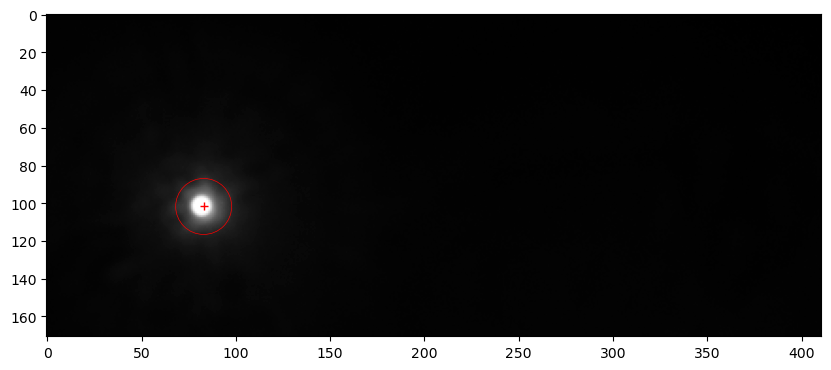

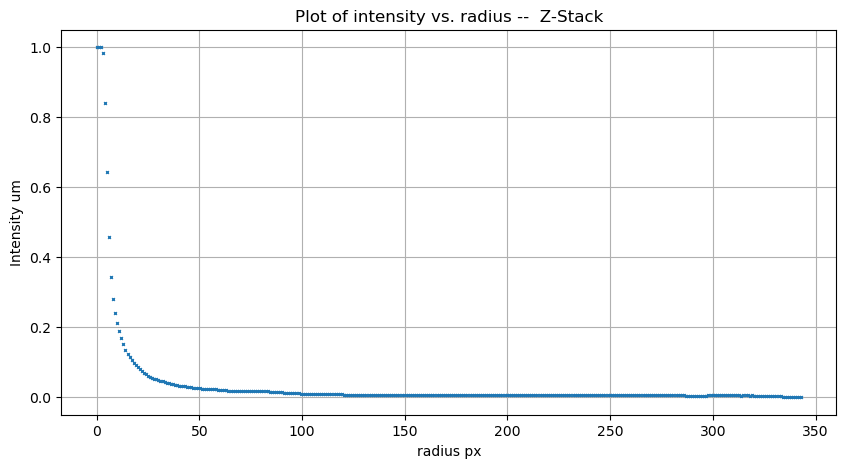

In [59]:
reqrd = 91
plot_frame(img[reqrd],centerx[reqrd],centery[reqrd],radius[reqrd])


fig, ax = plt.subplots()
xaxis = np.linspace(0,len(radial_profiles[reqrd][:]),len(radial_profiles[reqrd][:]))   #re-shifting to make lowest diameter zero
ax.plot(xaxis,radial_profiles[reqrd][:],'x',markersize=2)

#-----From here on its plotting---- 
#ax.plot(frames, l, ls='--',c='r',linewidth=2)
plt.xlabel('radius px')
plt.ylabel('Intensity um')
plt.title('Plot of intensity vs. radius --  Z-Stack')
plt.grid()


In [50]:


dii = np.asarray(radius) * 2*(res/1000)  #diameter in micron
frames = np.arange(len(dii))*step_size# 0.25 um is the step size of the z-stack!

In [51]:
shift = -1*frames[np.argmin(dii)]

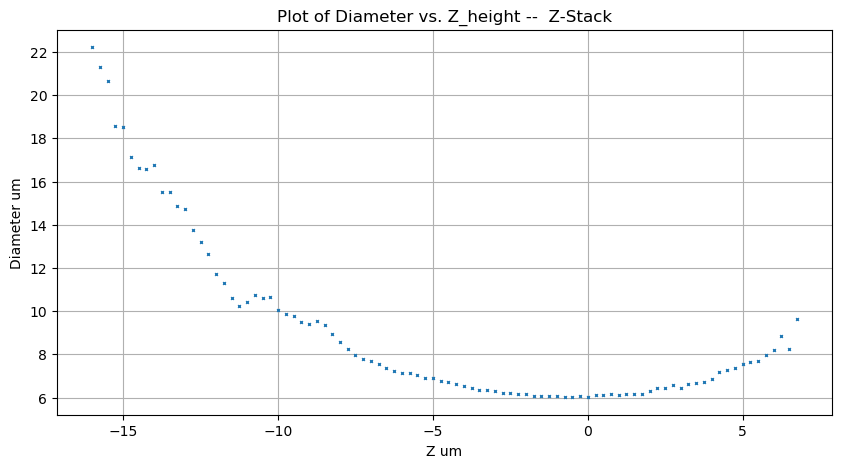

In [52]:

#calculate z height from the calculated attributes
fig, ax = plt.subplots()
frames = frames + shift   #re-shifting to make lowest diameter zero
ax.plot(frames,dii,'x',markersize=2)

#-----From here on its plotting---- 
#ax.plot(frames, l, ls='--',c='r',linewidth=2)
plt.xlabel('Z um')
plt.ylabel('Diameter um')
plt.title('Plot of Diameter vs. Z_height --  Z-Stack')
plt.grid()


Fit type is hyperbolic ( diameter^2 = A + B* z_height^2)
Gradient is (B) 1.2746414407458417
Intercept is (A)  7.641566051039711


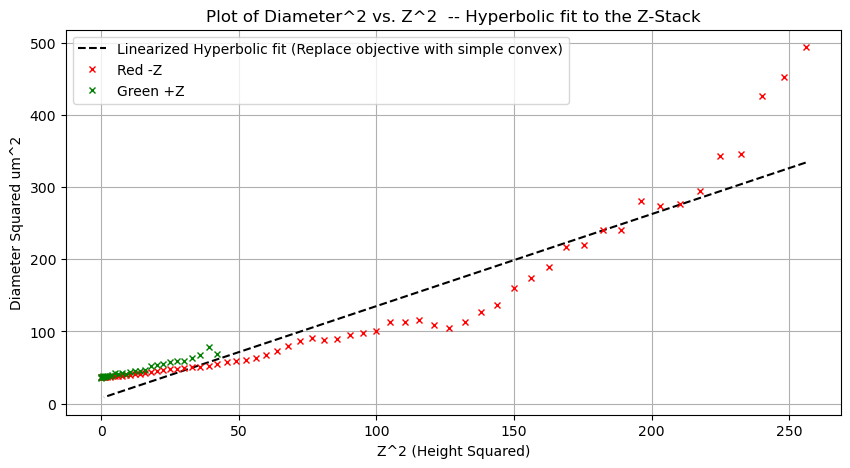

In [53]:
#fit a hyperbolic function to the above diameter vs height variation
plt.figure()
dii_squared = np.multiply(dii,dii)
frame_sqrd = np.multiply(frames, frames)
pred_params, uncert_cov = curve_fit(fun.line, frame_sqrd[1:np.argmin(dii)], dii_squared[1:np.argmin(dii)], method='lm')
x = np.linspace(0,15,100) + shift
yy = (pred_params[1] + pred_params[0]* np.multiply(x,x))
plt.plot(np.multiply(x,x), yy, ls='--',c='k')
plt.plot(frame_sqrd[0:np.argmin(dii)],dii_squared[0:np.argmin(dii)], 'rx',markersize=5)
plt.plot(frame_sqrd[np.argmin(dii):-1],dii_squared[np.argmin(dii):-1], 'gx',markersize=5)

plt.grid()
plt.xlabel('Z^2 (Height Squared)')
plt.ylabel('Diameter Squared um^2')
plt.title('Plot of Diameter^2 vs. Z^2  -- Hyperbolic fit to the Z-Stack')
plt.legend(['Linearized Hyperbolic fit (Replace objective with simple convex)','Red -Z', 'Green +Z'])
print('Fit type is hyperbolic ( diameter^2 = A + B* z_height^2)')
print('Gradient is (B)', pred_params[0])
print('Intercept is (A) ', pred_params[1])

